In [1]:
from torch.utils.data import Dataset, DataLoader
from numpy.random import Generator, PCG64

import matplotlib.pyplot as plt
import scipy.stats as st
import flax.linen as ln

import jax.numpy as jnp
import seaborn as sns
import numpy as np

import functools
import math
import jax

In [2]:
class IncreasingSine(Dataset):
    def __init__(self, size=1024, n_periods=5, noise_std=.35, seed=123):
        super().__init__()
        self.size = size
        self.n_periods = n_periods
        self.noise_std = noise_std
        self.rng = Generator(PCG64(seed))
        return
        
    def __len__(self):
        return self.n_periods
    
    def _generate_wave(self, n_periods):
        x = np.linspace(0, n_periods*2*np.pi, self.size, dtype=np.float32)
        x = np.sin(x)
        dx = np.gradient(x)
        x += self.rng.normal(0, self.noise_std, size=self.size)
        label = dx > .005
        return x.reshape((-1, 1)), label.reshape((-1, 1))
    
    def __getitem__(self, idx):
        x, label = self._generate_wave(idx + 1)
        return x, label
    
    def get_stack(self, n, n_periods=5):
        if isinstance(n_periods, list):
            assert len(n_periods) == n, 'n_periods list must match length of batch n'
            waves, labels = zip(*[
                self._generate_wave(n_p)
                for n_p
                in n_periods
            ])
        else:
            waves, labels = zip(*[
                self._generate_wave(n_periods)
                for _
                in range(n)
            ])
        waves = np.stack(waves)
        labels = np.stack(labels)
        return waves, labels
    
class SpatialIncreasingSine(IncreasingSine):
    def __init__(self, depth, step, **kwargs):
        super().__init__(**kwargs)
        waves, labels = zip(*[
            self._generate_wave(n)
            for n
            in np.arange(1, depth*step + 1, step)
        ])
        self._data = np.stack(waves)
        self._labels = np.stack(labels)
        assert self._data.shape[0] == depth, self._data.shape
        return
    
    def __len__(self):
        return self._data.shape[0]
    
    def __getitem__(self, idx):
        return self._data[idx], self._label[idx]    
    
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

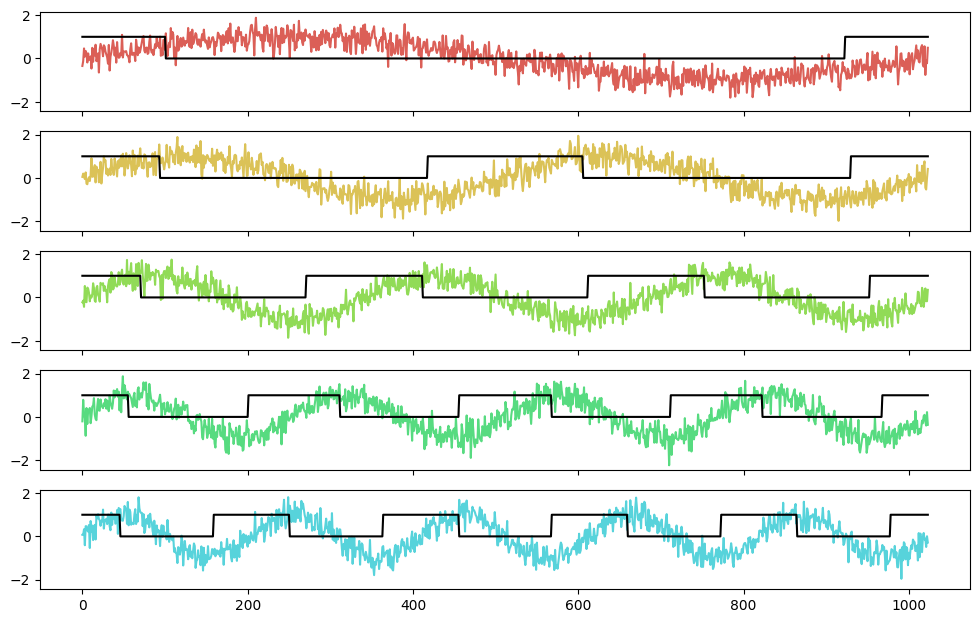

In [3]:
dataset = IncreasingSine()

cpal = sns.color_palette('hls', 8)
n_periodss = list(range(2, 7))
l = len(n_periodss)
fig, axs = plt.subplots(nrows=l, sharex=True, sharey=True, figsize=(12, l*1.5))
for i, (ax, color) in enumerate(zip(axs.ravel(), cpal)):
    wave, label = dataset[i]
    ax.plot(wave.squeeze(), color=color, label='noisy sine')
    ax.plot(label.squeeze(), color='black', label='increasing')
plt.show()

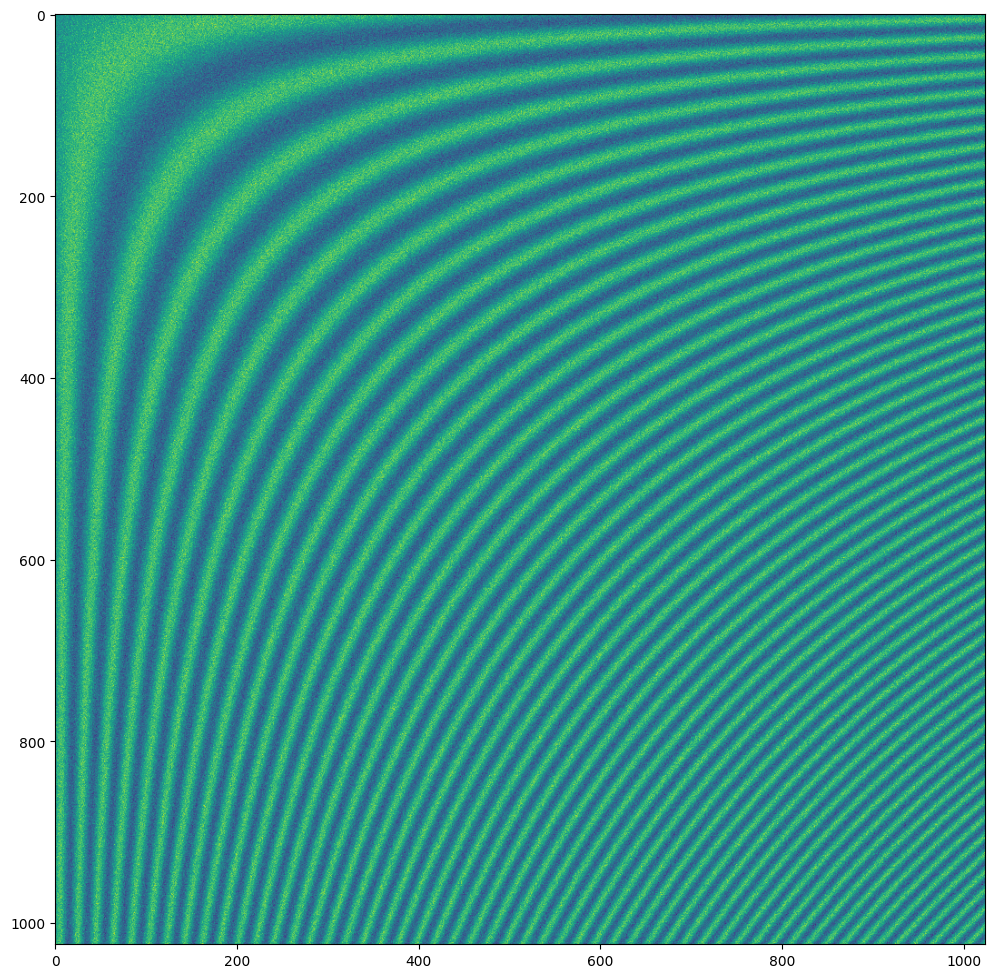

In [4]:
data_length = 1024
dataset = SpatialIncreasingSine(data_length, .05)

plt.figure(figsize=(12,16))
plt.imshow(dataset._data)
plt.show()

In [5]:
# from collections import deque
from typing import Optional

class Encoder(ln.Module):
    n_blocks : int=3
    init_features : int=4
    feature_scale : int=2
    kernel_width : int=3
    down_stride : int=2
        
    @ln.compact
    def __call__(self, x):
        residuals = list()
        f = self.init_features
        print('Input Size', x.shape)
        x = ln.Conv(features=f, kernel_size=(self.kernel_width,))(x)
        for block in range(self.n_blocks):
            print('Block Input', x.shape)
            residuals.append(x)
            x = ln.Conv(features=f, kernel_size=(self.kernel_width,), padding='SAME')(x)
            x = ln.activation.swish(x)
            x = ln.Conv(features=f, kernel_size=(self.kernel_width,), padding='SAME')(x)
            x = ln.activation.swish(x)
            if block != self.n_blocks - 1:
                x = ln.avg_pool(x, (self.down_stride,), strides=(self.down_stride,))
                f *= self.feature_scale
        return x, residuals
    
class Decoder(ln.Module):
    residuals : Optional[list]=None
    n_blocks : int=3
    init_features : int=16
    feature_scale : int=2
    kernel_width : int=3
    up_stride : int=2
        
    @ln.compact
    def __call__(self, x):
        f = self.init_features
        x = ln.ConvTranspose(f, kernel_size=(self.kernel_width,), padding='SAME')(x)
        for block in range(self.n_blocks):
            print('Block Input', x.shape)
            x = ln.Conv(features=f, kernel_size=(self.kernel_width,), padding='SAME')(x)
            x = ln.activation.swish(x)
            x = ln.Conv(features=f, kernel_size=(self.kernel_width,), padding='SAME')(x)
            x = ln.activation.swish(x)
            if self.residuals is not None:
                x += self.residuals[self.n_blocks - block]
#             if block != self.n_blocks - 1:
            f //= self.feature_scale
            x = ln.ConvTranspose(f, kernel_size=(self.kernel_width,), strides=(self.up_stride,), padding='SAME')(x)
        x = ln.Conv(features=1, kernel_size=(self.kernel_width,), padding='SAME')(x)
        print('Output Size', x.shape)
        return x

In [26]:
class Unet(ln.Module):
    encoder : Encoder
    decoder : Decoder
        
    @ln.compact
    def __call__(self, x):
        x, _ = self.encoder(x)
        y = self.decoder(x)
        return y
    
# https://www.machinelearningnuggets.com/jax-flax-lstm/
# https://flax.readthedocs.io/en/latest/_modules/flax/linen/recurrent.html
class BiGRU(ln.Module):
    encoder : ln.Module
    rnn_features : int=16
    pool_stride : int=(3,)
    
    def _encode(self, x):
        x, _ = self.encoder(x)
        x = ln.avg_pool(x, self.pool_stride)
        return x
    
    @ln.compact
    def __call__(self, x):
        print('Input Size', x.shape)
        x = jax.vmap(self._encode, in_axes=0, out_axes=0)(x)
        print('Encoding Size', x.shape)
        x = ln.Bidirectional(
            ln.RNN(ln.GRUCell(self.rnn_features)),
            ln.RNN(ln.GRUCell(self.rnn_features)),
        )(x)
        print('Post Recurrent Size', x.shape)
        x = ln.Dense(1)(x)
        print('Output Size', x.shape)
        return x

In [27]:
enc_model = Encoder(n_blocks=4)
enc_inpt = jax.random.normal(jax.random.PRNGKey(42), (128, 1024, 1))
enc_params = enc_model.init(jax.random.PRNGKey(42), enc_inpt)

# enc_oupt, residuals = enc_model.apply(enc_params, enc_inpt)

Input Size (128, 1024, 1)
Block Input (128, 1024, 4)
Block Input (128, 512, 4)
Block Input (128, 256, 8)
Block Input (128, 128, 16)
Input Size (128, 1024, 1)
Block Input (128, 1024, 4)
Block Input (128, 512, 4)
Block Input (128, 256, 8)
Block Input (128, 128, 16)


(128, 128, 32)

In [28]:
# residuals should probably not be stored with the model, but sent as a forward (keyword) argument
dec_model = Decoder(residuals=residuals)
dec_params = dec_model.init(jax.random.PRNGKey(42), enc_oupt)

# dec_oupt = dec_model.apply(dec_params, enc_oupt)

Block Input (128, 128, 16)
Block Input (128, 256, 8)
Block Input (128, 512, 4)
Output Size (128, 1024, 1)
Block Input (128, 128, 16)
Block Input (128, 256, 8)
Block Input (128, 512, 4)
Output Size (128, 1024, 1)


(128, 1024, 1)

In [29]:
# untrained, just for shape consistency
bigru_inpt = jnp.repeat(jnp.expand_dims(enc_oupt, axis=0), data_length, axis=0)

In [32]:
bigru_model = BiGRU(enc_model)
bigru_params = bigru_model.init(jax.random.PRNGKey(42), bigru_inpt)

Input Size (1024, 128, 128, 32)
Input Size (128, 128, 32)
Block Input (128, 128, 4)
Block Input (128, 64, 4)
Block Input (128, 32, 8)
Block Input (128, 16, 16)
Encoding Size (1024, 128, 14, 32)
Post Recurrent Size (1024, 128, 14, 32)
Output Size (1024, 128, 14, 1)
